# Mechanisms of Action (MoA) Prediction

Predicting multiple targets of the Mechanism of Action (MoA) response(s) of different samples (sig_id), given various inputs such as gene expression data and cell viability data.

## Some of the important terms used in the headings of the tables are presented here:
    
    g - : signifies gene expression data
    c - : signifies cell expression data
    cp_type : indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle)
    NOTE: (samples with control perturbations don't have MoAs)
    cp_time - treatment duration (24,48,72) Hours
    cp_dose - Dosage - HIGH or LOW

In [1]:
# Importing the multi label stratified k-fold 
# cross validator

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Initial random imports
import random
import os
import copy
import warnings
# warnings.filterwarnings('ignore')

# Importing numpy
import numpy as np

# Importing pandas
import pandas as pd

# Importing matplotlib
import matplotlib.pyplot as plt

# Importing seaborn
import seaborn as sns

# Importing sklearn
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# Importing pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Using GPU if available

In [2]:
# using GPU if available
if torch.cuda.is_available():
    device_code = 'cuda'
else:
    device_code = 'cpu'

In [3]:
# setting the seed, so that every time the seed is started from the same number

def set_seed_characteristics(seed=55):
    # Setting a random seed value
    
    random.seed(seed)
    
    # for guaranteering the reproducability of numbers by setting seed for NumPy
    
    np.random.seed(seed) 
    
    # for setting the seed for cuda or cpu
    
    torch.manual_seed(seed) 

    # To ensure that Pytorch doesnt just switch to the fastest possible algorithm but 
    # ensures that it selects a deterministic algorithm
    
    torch.backends.cudnn.deterministic = True

# Reading the CSV Files

In [4]:
training_features = pd.read_csv('input/train_features.csv')
# Reading the head rows and columns of train features
training_features_head = training_features.head()

training_targets_scored = pd.read_csv('input/train_targets_scored.csv')
# Reading the head rows and columns of train targets scored
training_targets_scored_head = training_targets_scored.head()

testing_features = pd.read_csv('input/test_features.csv')
# Reading the head rows and columns of train targets non-scored
testing_features_head = testing_features.head()

In [5]:
# Printing the head - training features 
training_features_head

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [6]:
# Printing the head - train targets scored 
training_targets_scored_head

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Printing the head - test features
testing_features_head

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


# Dataset classes, training and testing functions

In [8]:
# Pytorch data loader implementation of MoA dataset
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        train_tensor_dictionary = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return train_tensor_dictionary

# Pytorch data loader implementation of test dataset
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        test_tensor_dictionary = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return test_tensor_dictionary

In [9]:
# # Pytorch model for the MoA determination

# class Model(nn.Module):
    
#     # Instantiaing all the models before utilizing
#     # them later in the forward function.
#     def __init__(self, num_features, num_targets, hidden_size):
        
#         # super keyword used to access data from the parent
#         # pytorch.nn.Module class
#         super(Model, self).__init__()
#         # Applying batch normalization. This is done to standardize
#         # the input for each mini batches and will help reduce the
#         # number of epochs for which the training is done. This limits
#         # the covariate shift (this is the value by which the hidden
#         # layer values shift around) and allows to learn from a more 
#         # stable set of data. Sometimes, it also allows for a
#         # higher learning rate.This is also used for regularization
#         # and helps reduce over fitting. Generally, if batch 
#         # normalization is used, you can use a smaller dropout,
#         # which in turn means that lesser layers can be lost 
#         # in every step.
#         self.batch_norm1 = nn.BatchNorm1d(num_features)        
#         # For regularization purposes the dropout is set
#         # This is done by setting a probablity. Random 
#         # neural networks are picked at a probablity, say p
#         # or dropped at a probablity of 1-p. This is essential 
#         # to prevent overfitiing of the model and also reduces
#         # the computation time. A fully connected neural network, if
#         # run without dropout will start forming dependancies between
#         # each other and this can lead to over-fitting.
#         self.dropout1 = nn.Dropout(0.2)
#         # nn.utils.weight_norm : This is weight normalization. Usually,
#         #                        faster than batch normalization
#         # nn.Linear : Applying linear transform to the incoming data
#         #             and creates a single layer feed forward network.
#         # input size : num_features
#         # output size : hidden_size
#         self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
#         self.batch_norm2 = nn.BatchNorm1d(hidden_size)
#         self.dropout2 = nn.Dropout(0.2)
#         # input size : hidden_size
#         # output size : hidden_size
#         self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
#         self.batch_norm3 = nn.BatchNorm1d(hidden_size)
#         self.dropout3 = nn.Dropout(0.25)
#         # input size : hidden_size
#         # output size : num_targets
#         self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
#     # The forward function basically defines the model
#     def forward(self, x):
        
#         x = self.batch_norm1(x)
#         x = self.dropout1(x)
#         x = F.relu(self.dense1(x))
        
#         x = self.batch_norm2(x)
#         x = self.dropout2(x)
#         x = F.relu(self.dense2(x))
        
#         x = self.batch_norm3(x)
#         x = self.dropout3(x)
#         x = self.dense3(x)
        
#         return x

In [10]:
# Pytorch model for the MoA determination

class Model(nn.Module):
    
    # Instantiaing all the models before utilizing
    # them later in the forward function.
    def __init__(self, num_features, num_targets, hidden_size):
        
        # super keyword used to access data from the parent
        # pytorch.nn.Module class
        super(Model, self).__init__()
        # Applying batch normalization. This is done to standardize
        # the input for each mini batches and will help reduce the
        # number of epochs for which the training is done. This limits
        # the covariate shift (this is the value by which the hidden
        # layer values shift around) and allows to learn from a more 
        # stable set of data. Sometimes, it also allows for a
        # higher learning rate.This is also used for regularization
        # and helps reduce over fitting. Generally, if batch 
        # normalization is used, you can use a smaller dropout,
        # which in turn means that lesser layers can be lost 
        # in every step.
        self.batch_normalization_1 = nn.BatchNorm1d(num_features)        
        # For regularization purposes the dropout is set
        # This is done by setting a probablity. Random 
        # neural networks are picked at a probablity, say p
        # or dropped at a probablity of 1-p. This is essential 
        # to prevent overfitiing of the model and also reduces
        # the computation time. A fully connected neural network, if
        # run without dropout will start forming dependancies between
        # each other and this can lead to over-fitting.
        self.dropoutlayer_1 = nn.Dropout(0.2)
        # nn.utils.weight_norm : This is weight normalization. Usually,
        #                        faster than batch normalization
        # nn.Linear : Applying linear transform to the incoming data
        #             and creates a single layer feed forward network.
        # input size : num_features
        # output size : hidden_size
        self.denselayer_1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_normalization_2 = nn.BatchNorm1d(hidden_size)
        self.dropoutlayer_2 = nn.Dropout(0.2)
        # input size : hidden_size
        # output size : hidden_size
        self.denselayer_2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_normalization_3 = nn.BatchNorm1d(hidden_size)
        self.dropoutlayer_3 = nn.Dropout(0.1)
        # input size : hidden_size
        # output size : hidden_size
        self.denselayer_3 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_normalization_4 = nn.BatchNorm1d(hidden_size)
        self.dropoutlayer_4 = nn.Dropout(0.1)
        # input size : hidden_size
        # output size : hidden_size
        self.denselayer_4 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        
        self.batch_normalization_5 = nn.BatchNorm1d(hidden_size)
        self.dropoutlayer_5 = nn.Dropout(0.1)
        # input size : hidden_size
        # output size : num_targets
        self.denselayer_5 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    # The forward function basically defines the model
    def forward(self, forward_x):
        
        forward_x = self.batch_normalization_1(forward_x)
        forward_x = self.dropoutlayer_1(forward_x)
        forward_x = F.relu(self.denselayer_1(forward_x))
        
        forward_x = self.batch_normalization_2(forward_x)
        forward_x = self.dropoutlayer_2(forward_x)
        forward_x = F.relu(self.denselayer_2(forward_x))
        
        forward_x = self.batch_normalization_3(forward_x)
        forward_x = self.dropoutlayer_3(forward_x)
        forward_x = self.denselayer_3(forward_x)
        
        forward_x = self.batch_normalization_4(forward_x)
        forward_x = self.dropoutlayer_4(forward_x)
        forward_x = self.denselayer_4(forward_x)

        forward_x = self.batch_normalization_5(forward_x)
        forward_x = self.dropoutlayer_5(forward_x)
        forward_x = self.denselayer_5(forward_x)
        
        return forward_x

In [11]:
# Function to train the model
def trainingFunction(model, optimizer, scheduler, lossFunction, trainloader, device_code):
    model.train()
    training_loss = 0
    for training_data in trainloader:
        optimizer.zero_grad()
        inputs, targets = training_data['x'].to(device_code), training_data['y'].to(device_code)
        outputs = model(inputs)
        loss = lossFunction(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        training_loss += loss.item()    
    training_loss /= len(trainloader) 
    return training_loss

In [12]:
# Function to validate the model
def validationFunction(model, lossFunction, validationloader, device_code):
    model.eval()
    validation_loss = 0
    validation_predictions = []   
    for validation_data in validationloader:
        inputs, targets = validation_data['x'].to(device_code), validation_data['y'].to(device_code)
        outputs = model(inputs)
        loss = lossFunction(outputs, targets)
        validation_loss += loss.item()
        validation_predictions.append(outputs.sigmoid().detach().cpu().numpy())
    validation_loss /= len(validationloader)
    validation_predictions = np.concatenate(validation_predictions)
    return validation_loss, validation_predictions

In [13]:
# Adding the inference function
def inferenceFunction(model, inferenceloader, device_code):
    model.eval()
    inferences = [] 
    for data in inferenceloader:
        inputs = data['x'].to(device_code)
        with torch.no_grad():
            outputs = model(inputs)
        inferences.append(outputs.sigmoid().detach().cpu().numpy())   
    inferences = np.concatenate(inferences)  
    return inferences

In [14]:
# Adding dummy inserts to the cp_time and cp_dose columns
# Usually done to categorical variables
def addDummies(data):
    dummy_data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return dummy_data

# Preparing the dataset

In [15]:
set_seed_characteristics(seed=55)

In [16]:
# Seperating out the Gene expression Column and Cell Viability Column

gene_expression = [g for g in training_features.columns if g.startswith('g-')]
cell_viability = [c for c in training_features.columns if c.startswith('c-')]

In [17]:
# Since our dimensions are really high, we can resort to 
# using PCA for dimensionality reduction, but is still able 
# to capture the characteristics of the data.

# Now, this can be done by choosing a random dimension, and 
# having the same random state as before. By doing this
# we observe that we do not encounter
# any 'nan' errors during training.

# Doing PCA for the Gene expression data

# can choose any random number here
random_pca_dimension_genes = 20

# Concatenating the training and test set
data = pd.concat([pd.DataFrame(training_features[gene_expression]), pd.DataFrame(testing_features[gene_expression])])

# Performing PCA and converting to a random_pca_dimension_genes number of columns
pca_genes = PCA(n_components = random_pca_dimension_genes, random_state=55)

# Fitting the PCA transform
data_pca = pca_genes.fit_transform(data[gene_expression])

# Splitting the training and test columns
train_pca_genes = data_pca[:training_features.shape[0]] 
test_pca_genes = data_pca[-testing_features.shape[0]:]

# Converting training and testing  into Pandas data frame shape
train_pca_genes = pd.DataFrame(train_pca_genes, columns=[f'pca_G-{i}' for i in range(random_pca_dimension_genes)])
test_pca_genes = pd.DataFrame(test_pca_genes, columns=[f'pca_G-{i}' for i in range(random_pca_dimension_genes)])

# Concatenating these back to the original features
training_features = pd.concat((training_features, train_pca_genes), axis=1)
testing_features = pd.concat((testing_features, test_pca_genes), axis=1)

In [18]:
# Doing PCA for the Cell Viability Data

# can choose any random number here
random_pca_dimension_cells = 32

# Concatenating the training and test set
data = pd.concat([pd.DataFrame(training_features[cell_viability]), pd.DataFrame(testing_features[cell_viability])])

# Performing PCA and converting to a random_pca_dimension_cells number of columns
pca_cells = PCA(n_components = random_pca_dimension_cells, random_state=55)

# Fitting the PCA transform
data_pca = pca_cells.fit_transform(data[cell_viability])

# Splitting the training and test columns
train_pca_cells = data_pca[:training_features.shape[0]]
test_pca_cells = data_pca[-testing_features.shape[0]:]

# Converting training and testing  into Pandas data frame shape
train_pca_cells = pd.DataFrame(train_pca_cells, columns=[f'pca_C-{i}' for i in range(random_pca_dimension_cells)])
test_pca_cells = pd.DataFrame(test_pca_cells, columns=[f'pca_C-{i}' for i in range(random_pca_dimension_cells)])

# Concatenating these back to the original features
training_features = pd.concat((training_features, train_pca_cells), axis=1)
testing_features = pd.concat((testing_features, test_pca_cells), axis=1)

In [19]:
# Setting a desired threshold to calculate the VarianceThreshold.
# As per the math all the Features with a training-set variance 
# lower than this threshold will be removed.
variancethreshold = VarianceThreshold(threshold=0.7)

# Combining training and test features to create a single dataset
combined_data = training_features.append(testing_features)

# Fits to the data, before transforming it
combined_data_transformed = variancethreshold.fit_transform(combined_data.iloc[:, 4:])

# Extracting the training and the testing data out of the
# transformed data
training_features_transformed = combined_data_transformed[ : training_features.shape[0]]
testing_features_transformed = combined_data_transformed[-testing_features.shape[0] : ]

In [20]:
# Extracting the training features in a suitable 
# pandas dataset format and numbering the columns
# after the labels of 'sig_id', 'cp_type', 'cp_time', 'cp_dose'.
training_features = pd.DataFrame(training_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4), columns=['sig_id','cp_type','cp_time','cp_dose'])
training_features = pd.concat([training_features, pd.DataFrame(training_features_transformed)], axis=1)

# Extracting the testing features in a suitable 
# pandas dataset format and numbering the columns
# after the labels of 'sig_id', 'cp_type', 'cp_time', 'cp_dose'.

testing_features = pd.DataFrame(testing_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4), columns=['sig_id','cp_type','cp_time','cp_dose'])
testing_features = pd.concat([testing_features, pd.DataFrame(testing_features_transformed)], axis=1)

In [21]:
# Merging the columns

train = training_features.merge(training_targets_scored, on='sig_id')

# Removing rows with cp_type as ctl_vehicle 
# since control perturbations have no MoAs
# We are also manually setting the drop type as 
# true because we do not want to include them back 
# as a new column.

train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)

# Naturally, we have to get rid of them from the test dataset 
# as well

test = testing_features[testing_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

In [22]:
# Extracting the columns of the drugs that are sold from
# the train pandas dataframe

target = train[training_targets_scored.columns]

# Now that the ctl_vehicle drugs have been removed, we do not need
# cp_type. So we can go ahead and remove that columns as well.

train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

# extracting the columns in the targets 

target_columns = target.drop('sig_id', axis=1).columns.values.tolist()

# Dataset preparation complete

In [23]:
# multilabel stratified K Fold import causes a small warning and we do not want
# to show that in the notebook.
warnings.filterwarnings('ignore')

folds = train.copy()
number_of_folds = 3

# creating a 3 fold multilabel stratified K Fold
multilabel_k_fold = MultilabelStratifiedKFold(n_splits = number_of_folds)

# Standard k fold splitting. Here we are splitting into number_of_folds folds

for fol, (train_folds, validation_folds) in enumerate(multilabel_k_fold.split(X=train, y=target)):
    folds.loc[validation_folds, 'kfold'] = int(fol)
    
folds['kfold'] = folds['kfold'].astype(int)

# Isolating out the feature columns. This is done by first 
# Isolating the columns that are not present in the target
# followed by extracting the columns except the sig_id and 
# kfold.

feature_columns = [c for c in addDummies(folds).columns if c not in target_columns]
feature_columns = [c for c in feature_columns if c not in ['kfold','sig_id']]

# Declaring the HyperParameters

In [24]:
BATCH_SIZE = 128
max_epochs = 16
# When training neural networks, it is common to use 
# weight decay where after each update, the weights 
# are multiplied by a factor slightly less than 1
weight_decay = 1e-5
# deciding the initial learning rate
# It controls how quickly or slowly a neural
# network model can learn a model or a problem.
lr = 1e-3
# Boolean to decide on stopping early when the 
# validation_loss > best_loss
bool_early_stop = True
# steps to execute before early stopping
steps_early_stopping= 10
# number of features corresponding to the columns in the
# targets
num_features=len(feature_columns)
# number of targets corresponding to the columns in the
# features
num_targets=len(target_columns)
# in between neural netwrok size
hidden_size=1024

# Declaring the training functions and performing the training

In [25]:
# to plot validation loss
valid_loss_list = []
# to plot the training loss
train_loss_list = []
# to plot the best recorded loss
best_loss_list = []

In [26]:
def run_training(fold, seed):
    # declaring the list as global to plot validation loss
    global valid_loss_list
    # declaring the training loss list as global to plot
    # the training loss
    global train_loss_list
    # declaring the best loss list as global to plot the
    # best losses recorded
    global best_loss_list
    
    # setting the seed to start from the same number as 
    # explained previously
    set_seed_characteristics(seed)
    
    # adding dummy variables to the training set
    train = addDummies(folds)

    # extracting the validating rows numbers for the
    # respective k fold values
    val_idx = train[train['kfold'] == fold].index
    
    # Dropping all the rows from the training set
    # that does not belong to this kth fold
    train_necessary_rows = train[train['kfold'] != fold].reset_index(drop=True)
    # Dropping all the rows from the valiadtion set
    # that does not belong to this kth fold
    valid_necessary_rows = train[train['kfold'] == fold].reset_index(drop=True)
    
    # splitting the x and y values for training set
    train_features, train_targets  = train_necessary_rows[feature_columns].values, train_necessary_rows[target_columns].values
    # splitting the x and y values for test set
    validation_features, validation_targets =  valid_necessary_rows[feature_columns].values, valid_necessary_rows[target_columns].values
    
    # Converting the training data to standard pytorch 
    # dataset class format
    train_dataset = MoADataset(train_features, train_targets)
    
    # Converting the validation data to standard pytorch 
    # dataset class format
    valid_dataset = MoADataset(validation_features, validation_targets)
    
    # calling the pytorch data loading utility for the
    # training set
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    # calling the pytorch data loading utility for the
    # validation set  
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Declaring the model and can be tuned here
    # using the hyper parameters
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    # moving the model to GPU if available,
    # else will run it on CPU itself
    model.to(device_code)
    
    # A standard optimizer. Adam optimizer is widely used
    # because it combines the advantages of the Adaptive gradient
    # algorithm and the root mean square propogation. Basically, it does
    # not stick to one learning rate and adapts it to the problem. 
    # It is widely known to offer good results really fast.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # We use a learning rate scheduler to converge to the lowest
    # loss faster. This is also seen to provide higher accuracy.
    # This can be tuned.
    # Some of the optimizers I tried here are
    # optim.lr_scheduler.OneCycleLR
    # optim.lr_scheduler.StepLR
    
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.05, div_factor=1.5e3, 
                                              max_lr=1e-2, epochs=max_epochs, steps_per_epoch=len(trainloader))
    
    # after research I saw that the Binary cross
    # entropy loss with sigmoid layer works well
    lossFunction = nn.BCEWithLogitsLoss()
    
    # stops when the error starts increaseing. Setting the counter
    # to track this
    steps_before_early_stop = 0
    # general out of fold array shape
    out_of_fold = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    # declaring a very high value as an 
    # initial loss for each kth fold
    best_loss = np.inf
    
    # looping through the epochs
    for epoch in range(max_epochs):
        
        # training the model
        training_loss = trainingFunction(model, optimizer,scheduler, lossFunction, trainloader, device_code)
        print('epoch : ',epoch,'>> training_loss : ',training_loss)
        train_loss_list.append(training_loss)
        validation_loss, validation_predictions = validationFunction(model, lossFunction, validloader, device_code)
        print('epoch : ',epoch,'>> validation : ',validation_loss)
        valid_loss_list.append(validation_loss)
        
        # checking if the loss is decreasing
        if validation_loss < best_loss:
            best_loss = validation_loss
            best_loss_list.append(best_loss)
            # Updating the out of fold predictions
            out_of_fold[val_idx] = validation_predictions
            # saving the model and data for this kth fold
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        # Handling the increasing loss by calling 
        # early stopping
        elif(bool_early_stop == True):
            
            # breaks out of the loop when this happens
            steps_before_early_stop += 1
            if (steps_before_early_stop >= steps_early_stopping):
                break
    # adding dummy variables to the test set
    test_ = addDummies(test)       
    
    # extracting the x_test
    x_test = test_[feature_columns].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(num_features=num_features,num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    # uploading the saved data for this kth fold
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    # again uploading the model to GPU, if available
    model.to(device_code)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    # evaluates the model
    predictions = inferenceFunction(model, testloader, device_code)
    
    return out_of_fold, predictions

In [27]:
def executeKFold(number_of_folds, seed):
    # standard size for the out of fold predictions
    out_of_fold = np.zeros((len(train), len(target_columns)))
    # same size for all of the predictions
    predictions = np.zeros((len(test), len(target_columns)))
    
    for each_k_fold in range(number_of_folds):
        print('Fold Number : ', each_k_fold)
        out_of_fold_, pred_ = run_training(each_k_fold, seed)
        
        # adding all the predictions
        predictions += pred_ / number_of_folds
        # adding all the out of fold predictions
        out_of_fold += out_of_fold_
        print("------------------------")
        
    k_th_prediction = predictions
    return out_of_fold, k_th_prediction

In [28]:
# setting a standard seed number
SEED = [55]
# general out of fold array shape
out_of_fold = np.zeros((len(train), len(target_columns)))
# general predictions array shape
predictions = np.zeros((len(test), len(target_columns)))

# for seed in SEED:
out_of_fold_, predictions_ = executeKFold(number_of_folds, SEED[0])
out_of_fold += out_of_fold_ / len(SEED)
predictions += predictions_ / len(SEED)

train[target_columns] = out_of_fold
test[target_columns] = predictions

Fold Number :  0
epoch :  0 >> training_loss :  0.2788736069979875
epoch :  0 >> validation :  0.021623456240471066
epoch :  1 >> training_loss :  0.020091968256494272
epoch :  1 >> validation :  0.01922281719101914
epoch :  2 >> training_loss :  0.019972266159627747
epoch :  2 >> validation :  0.01886744482506966
epoch :  3 >> training_loss :  0.019043210343174313
epoch :  3 >> validation :  0.018996690303601068
epoch :  4 >> training_loss :  0.018774466394730235
epoch :  4 >> validation :  0.018413769980442935
epoch :  5 >> training_loss :  0.01869301253362842
epoch :  5 >> validation :  0.01853232747264977
epoch :  6 >> training_loss :  0.01865103912094365
epoch :  6 >> validation :  0.018168202376571196
epoch :  7 >> training_loss :  0.018572327146387617
epoch :  7 >> validation :  0.01888334468520921
epoch :  8 >> training_loss :  0.018362585228422414
epoch :  8 >> validation :  0.018195184943234098
epoch :  9 >> training_loss :  0.018180621188619864
epoch :  9 >> validation :  0.

# Evaluating the logarithmic loss function applied to each drug-MoA annotation pair.

In [29]:
validation_df = training_targets_scored.drop(columns=target_columns).merge(train[['sig_id']+target_columns], on='sig_id', how='left').fillna(0)
# True target values
true_target = training_targets_scored[target_columns].values
# Predicted target values
predicted_target = validation_df[target_columns].values
cross_validation_score = 0

# Now we can calculate the cross entropy loss

for i in range(len(target_columns)):
    cross_validation_score_target = log_loss(true_target[:, i], predicted_target[:, i])
    cross_validation_score += cross_validation_score_target / target.shape[1]  

print(" The Cross Validation loss is :>> ", cross_validation_score)

 The Cross Validation loss is :>>  0.015734850054263057


# Plotting the Validation loss for each fold

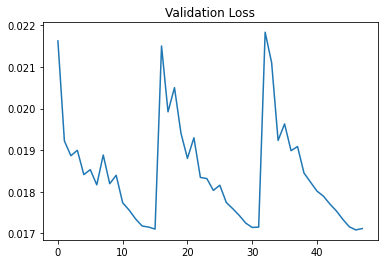

In [39]:
plt.plot(valid_loss_list)
plt.title('Validation Loss')
plt.savefig('valid_loss_list.png')

# Plotting the Training loss for each fold

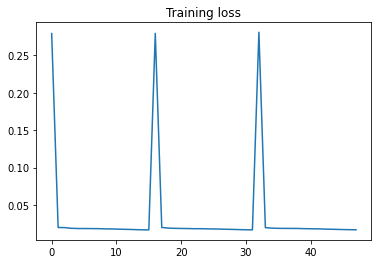

In [40]:
plt.plot(train_loss_list)
plt.title('Training loss')
plt.savefig('train_loss_list.png')

# Plotting the Best recorded loss for each fold

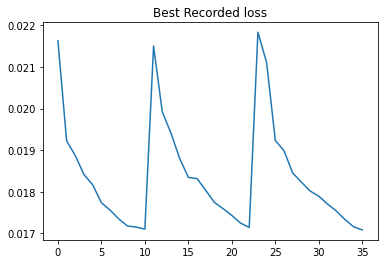

In [41]:
plt.plot(best_loss_list)
plt.title('Best Recorded loss')
plt.savefig('best_loss_list.png')